In [90]:
import os
import datetime
import sys
import time
import requests
from datetime import datetime, timedelta
import json
import numpy as np
from sentence_transformers import SentenceTransformer
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import r2_score
import nltk
from nltk.tokenize import sent_tokenize
import matplotlib.pyplot as plt

In [2]:
EARLIEST_DATE = datetime(2019, 12, 19)

In [3]:
model = SentenceTransformer('bert-large-nli-mean-tokens')

I0514 18:45:41.421535 26524 SentenceTransformer.py:29] Load pretrained SentenceTransformer: bert-large-nli-mean-tokens
I0514 18:45:41.423531 26524 SentenceTransformer.py:32] Did not find a '/' or '\' in the name. Assume to download model from server.
I0514 18:45:41.426522 26524 SentenceTransformer.py:67] Load SentenceTransformer from folder: C:\Users\Jai/.cache\torch\sentence_transformers\public.ukp.informatik.tu-darmstadt.de_reimers_sentence-transformers_v0.2_bert-large-nli-mean-tokens.zip
I0514 18:45:41.476432 26524 configuration_utils.py:281] loading configuration file C:\Users\Jai/.cache\torch\sentence_transformers\public.ukp.informatik.tu-darmstadt.de_reimers_sentence-transformers_v0.2_bert-large-nli-mean-tokens.zip\0_BERT\config.json
I0514 18:45:41.477401 26524 configuration_utils.py:319] Model config BertConfig {
  "_num_labels": 2,
  "architectures": null,
  "attention_probs_dropout_prob": 0.1,
  "bad_words_ids": null,
  "bos_token_id": null,
  "decoder_start_token_id": null,
 

In [4]:
def fit_beta_reg(y, X):
    binom_glm = sm.GLM(y, X, family=sm.families.Binomial())
    binom_results = binom_glm.fit()
    return binom_results
# plt.plot(y, binom_results.predict(X), 'o', alpha=0.2);

In [5]:
def goodness_of_fit(model, true, X):
    y_predicted = model.get_prediction(X)
    pred_vals = y_predicted.summary_frame()['mean']
    print(r2_score(true, pred_vals))

In [6]:
def sentence_tokenize(text):
    return sent_tokenize(text)

In [7]:
def none_or_empty(text):
    return text is None or len(text) == 0 or text == "[removed]" or text == '[deleted]'

In [8]:
def get_dates(latest_date):
    # Get all week increments from earliest date until present
    dates = []
    epochs = []
    curr = EARLIEST_DATE
    while curr < latest_date:
        dates.append(curr.strftime("%m/%d/%Y"))
        epochs.append(int(curr.timestamp()))
        curr += timedelta(weeks=1)
    dates.append(latest_date.strftime("%m/%d/%Y"))
    epochs.append(int(latest_date.timestamp()))
    return dates, epochs

In [66]:
def get_week_score(dirname, week_file):
    # Get data stored for subreddit
    
    data = get_file_data(dirname, week_file)
    all_means = np.array([])
    def get_post_score(text):
#         sen_split = sentence_tokenize(text)
        encoded_sen = model.encode(text)
        valence_pred_results = valence_model.get_prediction(encoded_sen)
        valence_pred_means = valence_pred_results.predicted_mean
        arousal_pred_results = arousal_model.get_prediction(encoded_sen)
        arousal_pred_means = arousal_pred_results.predicted_mean
        dominance_pred_results = dominance_model.get_prediction(encoded_sen)
        dominance_pred_means = dominance_pred_results.predicted_mean
        return valence_pred_means, arousal_pred_means, dominance_pred_means
    
    valid_text = []
    for element in data:
        valid_text.extend(sentence_tokenize(element))
    v_scores, a_scores, d_scores = get_post_score(valid_text)
    print(len(valid_text) == len(v_scores) == len(a_scores) == len(d_scores))
    return np.mean(v_scores), np.mean(a_scores), np.mean(d_scores), np.std(v_scores), np.std(a_scores), np.std(d_scores)
#         try:
#             text = element['body']
#         except KeyError:
#             text = element['selftext'] if not none_or_empty(element['selftext']) else element['title']
#         valid_text.extend(sentence_tokenize(text))
# #     print(len(valid_text))
#     scores = get_post_score(valid_text)
# #     print(len(scores))
#     return np.mean(scores), np.std(scores) 
        

In [64]:
5==5==5==5

True

# SETUP AND TEST

In [10]:
df_vad = pd.read_csv('Vad Lexicon/lexicon.txt', delimiter='\t', header = 0)
df_vad = df_vad.dropna()
df_vad.index = df_vad['Word']
df_vad = df_vad[['Valence', 'Arousal', 'Dominance']]

In [11]:
vad_words = list(df_vad.index)
vad_embeddings = model.encode(vad_words)


Batches: 100%|██████████| 2501/2501 [17:36<00:00,  1.24it/s]


In [12]:
vad_embeddings = np.array(vad_embeddings)

In [13]:
valence = np.array(df_vad['Valence'].tolist())
arousal  = np.array(df_vad['Arousal'].tolist())
dominance = np.array(df_vad['Dominance'].tolist())

In [39]:
titles = ['valence', 'arousal', 'dominance']
dims = [valence, arousal, dominance]
# for i in range(len(titles)):
#     reg_model = fit_beta_reg(dims[i], vad_embeddings)
#     goodness_of_fit(reg_model, dims[i], vad_embeddings)
    
valence_model = fit_beta_reg(valence, vad_embeddings)
goodness_of_fit(valence_model, valence, vad_embeddings)
arousal_model = fit_beta_reg(arousal, vad_embeddings)
goodness_of_fit(arousal_model, arousal, vad_embeddings)
dominance_model = fit_beta_reg(dominance, vad_embeddings)
goodness_of_fit(dominance_model, dominance, vad_embeddings)

0.719292563382529
0.6015808128609319
0.6420082478782179


In [46]:
# DIRNAME = 'state_analysis/'
def get_file_data(dirname, file_name):
    with open(f'{dirname}{file_name}', 'r', encoding="UTF-8") as file:
        data = file.readlines()
        return [line.strip() for line in data] 


In [32]:
def sort_files(dirname, cutoff=1):
    sort_map = {}
    max_int = cutoff
    for file in os.listdir(dirname):
        dot_index = file.index(".")
        week = int(file[4:dot_index])
        if week >= cutoff:
            if sort_map.get(week) is None:
                sort_map[week] = [file]
            else:
                sort_map[week].append(file)
        if week >= max_int:
            max_int = week
    sorted_files = []
    for i in range(cutoff, max_int+1):
        sorted_files.extend(sort_map[i])
    return sorted_files
        

In [67]:
for i in range(1, 2):
    print(f"Region {i}")
    dirname = f"Region{i}/"
    sorted_files = sort_files(dirname, cutoff=10)
    valence_means = []
    valence_stds = []
    arousal_means = []
    arousal_stds = []
    dominance_means = []
    dominance_stds = [] 
    for file in sorted_files:
        print(file)
        vmean, amean, dmean, vstd, astd, dstd = get_week_score(dirname, file)
        valence_means.append(vmean)
        valence_stds.append(vstd)
        arousal_means.append(amean)
        arousal_stds.append(astd)
        dominance_means.append(dmean)
        dominance_stds.append(dstd)
    
        

Region 1
Week10.Midwest.txt


Batches: 100%|██████████| 57/57 [02:04<00:00,  4.77s/it]


True
Week10.Mountain Plains.txt


Batches: 100%|██████████| 93/93 [03:22<00:00,  4.11s/it]


True
Week10.Northeast.txt


Batches: 100%|██████████| 85/85 [03:19<00:00,  5.78s/it]


True
Week10.Southeast.txt


Batches: 100%|██████████| 110/110 [03:50<00:00,  6.48s/it]


True
Week10.West Coast.txt


Batches: 100%|██████████| 321/321 [11:20<00:00,  6.50s/it]


True
Week11.Midwest.txt


Batches: 100%|██████████| 383/383 [13:43<00:00,  7.70s/it]


True
Week11.Mountain Plains.txt


Batches:  80%|███████▉  | 592/744 [15:51<04:44,  1.87s/it]

KeyboardInterrupt: 

0.15527188909741577

In [27]:
dates, epochs = get_dates(datetime.datetime.utcnow())
# diachronic = np.bincount(np.digitize(state_json, epochs))
# d_vals = ','.join(map(str, map(int, diachronic[1:])))
# dia_file.write(f"{state},{d_vals}\n")

(['12/19/2019',
  '12/26/2019',
  '01/02/2020',
  '01/09/2020',
  '01/16/2020',
  '01/23/2020',
  '01/30/2020',
  '02/06/2020',
  '02/13/2020',
  '02/20/2020',
  '02/27/2020',
  '03/05/2020',
  '03/12/2020',
  '03/19/2020',
  '03/26/2020',
  '04/02/2020',
  '04/09/2020',
  '04/16/2020',
  '04/23/2020',
  '04/30/2020',
  '05/07/2020',
  '05/12/2020'],
 [1576731600,
  1577336400,
  1577941200,
  1578546000,
  1579150800,
  1579755600,
  1580360400,
  1580965200,
  1581570000,
  1582174800,
  1582779600,
  1583384400,
  1583985600,
  1584590400,
  1585195200,
  1585800000,
  1586404800,
  1587009600,
  1587614400,
  1588219200,
  1588824000,
  1589310269])

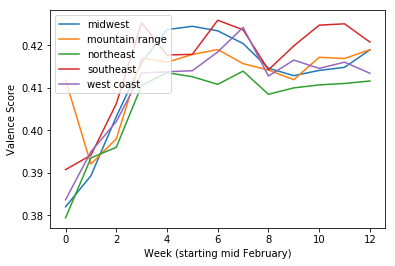

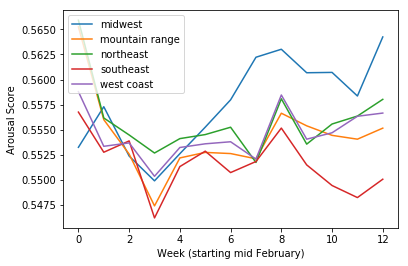

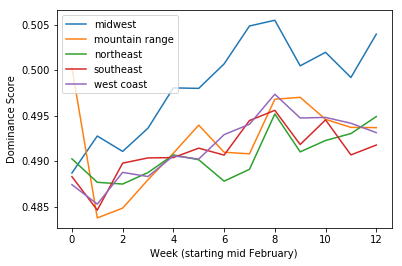

In [129]:
with open("emotion_data_10_12.json", "r") as file:
    data = file.readlines()
    em_data1 = json.loads(data[0])
with open("emotion_data_13_15.json", "r") as file:
    data = file.readlines()
    em_data2 = json.loads(data[0])
with open("emotion_data_16_22.json", "r") as file:
    data = file.readlines()
    em_data3 = json.loads(data[0])
for key in ['valence', 'arousal', "dominance"]:
    means = np.array(em_data1[f'{key}_means']) #.reshape(-1, 5).
    means = np.append(means, np.array(em_data2[f'{key}_means']))
    means = np.append(means, np.array(em_data3[f'{key}_means']))
    means = means.reshape(-1, 5).T
    stds = np.array(em_data1[f'{key}_stds']) #.reshape(-1, 5).
    stds = np.append(stds, np.array(em_data2[f'{key}_stds']))
    stds = np.append(stds, np.array(em_data3[f'{key}_stds']))
    stds = means.reshape(-1, 5).T
    # plt.scatter([i for i in range(5)], vmeans)
#     print(vmeans)
    regions = ['midwest', 'mountain range', 'northeast', 'southeast', 'west coast']
    for i in range(len(means)):
        plt.plot([j for j in range(means.shape[1])], means[i], label=regions[i])
#         plt.errorbar([j for j in range(means.shape[1])], means[i], stds[i], linestyle='-', marker='^')
    plt.legend(loc='upper left')
    plt.xlabel("Week (starting mid February)")
    plt.ylabel(f'{key.capitalize()} Score')
    plt.savefig(f"region_1_{key}.png")
    plt.show()
    
    # plt.legend(loc="lower left")

In [130]:
arousal_stds

[0.11582930275760166,
 0.11794256047837133,
 0.11488626321489989,
 0.12268604084806138,
 0.12054126068118762,
 0.12061394421536295]